## Load data

In [47]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

In [7]:
dir_s = '../portfolios/OLMAR/original_csv/'
files_s = ['AMD.csv', 'CERN.csv', 'COST.csv', 'DELL.csv', 'GPS.csv', 'INTC.csv', 'MMM.csv']

In [260]:
dfs = []
for f_s in files_s:
    f_s2 = dir_s + f_s
    df1 = pd.read_csv(f_s2, usecols=['Date', 'Adj Close'], index_col='Date') 
    df1.columns = [f_s[:-4]]
    df1 = df1.dropna()
    dfs.append(df1)
df = pd.concat(dfs, axis=1)
df = df.dropna()
df_tgt = df['AMD'].pct_change() # targeting AMD for prediction
df = df[1:]
df_tgt = df_tgt[1:]

get historical data in format of LSTM : (time, input_size)

In [263]:
df_in = df # this should be run after df_tgt is obtained
df_in_np = df_in.to_numpy(np.single)
df_tgt_np = df_tgt.to_numpy(np.single)

tensor_in = torch.from_numpy(df_in_np)
tensor_tgt = torch.from_numpy(df_tgt_np)

In [248]:
class Index_data(Dataset):
    def __init__(self, in_data, tgt, n_window):
        """
        make it to each n_window old data gives next AMD price
        :param in_data: torch.tensor
        :param tgt: torch.tensor
        """
        self.in_data = in_data[:-1]
        self.tgt = tgt[n_window:]
        self.n_window = n_window
        
    def __getitem__(self, ii):
        """
        nets.Net assumes that data are given as (in_data, tgt)
        normalize by the first element
        """
        return (self.in_data[ii:ii+self.n_window]/self.in_data[ii], 
                self.tgt[ii])
    
    def __len__(self):
        return len(self.tgt)

In [268]:
n_window = 10
n_history = len(df_in)
n_train = n_history//10*8
n_test = n_history - n_train
batch_size = 64
train_dset = Index_data(tensor_in[:n_train], tensor_tgt[:n_train], n_window)
test_dset = Index_data(tensor_in[n_train:], tensor_tgt[n_train:], n_window)
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Make model

In [50]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
lib_s = '/home/adminuser/public/libs/pytorch_examples/basic_networks'
sys.path.append(lib_s)
import generate_model as nets

In [302]:
class Predictor_rnn(nets.Net):
    def __init__(self, rnn=None, downnet=None,
                 loss=None, optimizer=None, device='cuda',
                 dim_input=100, dim_hidden=200):
        """
        net is consists of [embed, rnn, downnet]
        :param downnet: define downstream job
        """
        super(Predictor_rnn, self).__init__(loss=loss, device=device)
        
        if rnn is None:
            self.rnn = nn.LSTM(input_size=dim_input, 
                               hidden_size=dim_hidden, 
                               num_layers= 2,
                               batch_first=True,
                               bidirectional=False)
        else:
            self.rnn = rnn
            
        if downnet is None:
            self.downnet = nets.get_MLP([dim_hidden, dim_hidden*2, 1], 
                                        dropout=0.5, end=True)
        else:
            self.downnet = downnet
        
        self.init_weights()
        
        self.rnn = self.rnn.to(device)
        self.downnet = self.downnet.to(device)
        
        parms = list(self.rnn.parameters())
        parms += list(self.downnet.parameters())
        self.optimizer = optimizer(parms)
        
    
    def set_train(self):
        self.rnn.train()
        self.downnet.train()
        
    def set_eval(self):
        self.rnn.eval()
        self.downnet.eval()
    
    def init_weights(self):
        for ii, layer in enumerate(self.downnet):
            if 'Linear' in str(layer):
                torch.nn.init.xavier_uniform_(self.downnet[ii].weight)

    def forward(self, x):
        #print(x.size())
        #print(self.rnn(x))
        out, hidden = self.rnn(x)
        #print(out[:,-1].size())
        out = self.downnet(out[:,-1]) # choose last output
        return out.view(-1)

    def run_eval(self, data):
        self.set_eval()
        loss = 0
        outs = None
        tgts = None
        with torch.no_grad():
            for i_batch, data_batch in enumerate(data):
                data_in, tgt = data_batch
                data_in = data_in.to(self.device)
                tgt = tgt.to(self.device)
                out = self.forward(data_in)
                #print('loss', loss, self.loss)
                loss += self.loss(out, tgt).cpu().numpy()
                out = out.cpu().numpy()
                #print('loss===', loss)
                tgt = tgt.cpu().numpy()
                if outs is None:
                    outs = out
                    tgts = tgt
                else:
                    outs = np.concatenate((outs, out), axis=0)
                    tgts = np.concatenate((tgts, tgt), axis=0)
        loss /= 1.0*(i_batch+1)
        print('evaluate', 'loss', loss, 'accuracy : define function')
        return outs, tgts, loss

    """
    def run_batch(self, i_batch, data):
        self.optimizer.zero_grad()
        #print(data)
        data_in, tgt = data
        
        data_in = data_in.to(self.device)
        tgt = tgt.to(self.device)
        out = self.forward(data_in)
        loss = self.loss(out, tgt)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().item()
    """
    # If you customize learning, fix run_batch, run_train, run_eval
    #def run_batch(self, i_batch, data):
    #    pass

In [303]:
dim_input = df_in_np.shape[-1]
dim_hidden = 500
loss = nn.MSELoss() # which combines logsoftmax and nll loss
optimizer = optim.Adam
device = torch.device("cuda:0")

predictor = Predictor_rnn(loss=loss, optimizer=optimizer, 
                          device=device, dim_input=dim_input, 
                          dim_hidden=dim_hidden)

In [304]:
predictor.run_train(n_epoch=200, data=train_loader)

epoch 0 loss 0.007778075733222067
eval_train evaluate loss 0.003387706959620118 accuracy : define function
epoch 1 loss 0.002349765532805274
eval_train evaluate loss 0.0015008011638807754 accuracy : define function
epoch 2 loss 0.0018534893014778694
eval_train evaluate loss 0.001433419114133964 accuracy : define function
epoch 3 loss 0.0018595960767318804
eval_train evaluate loss 0.0014582935604266823 accuracy : define function
epoch 4 loss 0.001742307849538823
eval_train evaluate loss 0.0014489820304637155 accuracy : define function
epoch 5 loss 0.0018816638893137375
eval_train evaluate loss 0.0014479301947479446 accuracy : define function
epoch 6 loss 0.0016936363846374056
eval_train evaluate loss 0.0015120414008075991 accuracy : define function
epoch 7 loss 0.0016660660350074372
eval_train evaluate loss 0.0014076858021629354 accuracy : define function
epoch 8 loss 0.001704642145584027
eval_train evaluate loss 0.001501493031779925 accuracy : define function
epoch 9 loss 0.00160543783

## Check

In [225]:
import matplotlib.pyplot as plt

In [305]:
tgts = None
preds = None
with torch.no_grad():
    for data_batch in test_loader:
        data_in, tgt = data_batch
        data_in = data_in.to(device)
        tgt = tgt.numpy()
        out = predictor.forward(data_in).cpu().numpy()
        if preds is None:
            preds = out
            tgts = tgt
        else:
            preds = np.concatenate((preds, out), axis=0)
            tgts = np.concatenate((tgts, tgt), axis=0)
preds = preds.reshape(-1)
tgts = tgts.reshape(-1)

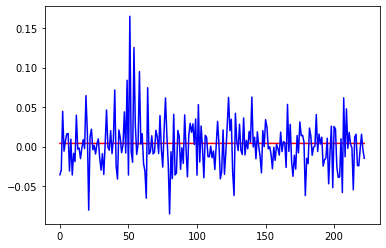

In [306]:
xs = range(len(preds))
plt.plot(xs, preds, color='r')
plt.plot(xs, tgts, color='b')
plt.show()

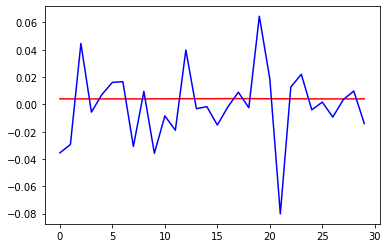

In [307]:
x_lim = 30
plt.plot(xs[:x_lim], preds[:x_lim], color='r')
plt.plot(xs[:x_lim], tgts[:x_lim], color='b')
plt.show()

In [308]:
preds

array([0.00405974, 0.00401071, 0.00401111, 0.00399112, 0.00400899,
       0.00401835, 0.00402547, 0.00400957, 0.00400952, 0.00406704,
       0.00407123, 0.00410094, 0.00416425, 0.00414258, 0.00413061,
       0.00416722, 0.0042227 , 0.0041813 , 0.00421616, 0.00415647,
       0.00408907, 0.00408076, 0.00411696, 0.00407618, 0.00404733,
       0.00400664, 0.00400045, 0.00399909, 0.00399198, 0.00404403,
       0.00409118, 0.0040611 , 0.00406437, 0.00409822, 0.00409434,
       0.00412223, 0.00411687, 0.00412879, 0.00411717, 0.00409971,
       0.0040956 , 0.00407412, 0.00399904, 0.00399181, 0.00400749,
       0.00401235, 0.00401731, 0.00403453, 0.00403524, 0.00403154,
       0.00408459, 0.00405371, 0.00399919, 0.00398572, 0.00396761,
       0.00393918, 0.0039205 , 0.00392819, 0.00390763, 0.00392944,
       0.00389209, 0.00396236, 0.00395109, 0.00394887, 0.0040023 ,
       0.00404651, 0.0040491 , 0.00405893, 0.00412634, 0.00411597,
       0.00413144, 0.0041013 , 0.0040574 , 0.00400037, 0.00404